<a href="https://colab.research.google.com/github/mscholl96/mad-recime/blob/recipe1M-parser/data/recipe1M/parser/ingEval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ingredient Evaluation

In [6]:
# network graph
!pip install plotly
!pip install chart-studio

In [7]:
import pandas as pd
import numpy as np
import itertools
import re

# network graph
import plotly.graph_objects as go
import networkx as nx
from chart_studio import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go

import random
import matplotlib.pyplot as plt

In [8]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [9]:
FILE_DIR = 'drive/My Drive/_Master/09_KI_ML/TP2/Datasets/Recipe1M/'

# Get valid recipes from pickle

In [10]:
baseFrame = pd.read_pickle(FILE_DIR + '20220126/recipes_valid_300k.pkl')
baseFrame.head()

,title,ingredients,instructions
id,,,
000033e39b,Dilly Macaroni Salad Recipe,amount unit ingredient 0 1....,0 Cook macaroni according to package direct...
000035f7ed,Gazpacho,amount unit ingredient 0 8.0 ...,0 Add the tomatoes to a food processor with...
00003a70b1,Crunchy Onion Potato Bake,amount unit ingredient 0 1.0...,0 Preheat oven to 350 degrees Fah...
00004320bb,Cool 'n Easy Creamy Watermelon Pie,amount unit ingredient 0 1.0...,0 Dissolve Jello in boiling water. 1 ...
0000631d90,Easy Tropical Beef Skillet,amount unit ingredient 0...,"0 In a large skillet, toast the coconut ove..."


## Create ingredient Frame

In [11]:
#ingredient normalization TODO: add instructions here to have the full frame
def flatten_ing(row):
  return np.column_stack((row['amount'].tolist(), row['unit'].tolist(), row['ingredient'].tolist()))

tempSeries = baseFrame['ingredients'].apply(lambda x: flatten_ing(x)).explode()
baseFrame  = pd.DataFrame(tempSeries.tolist(), index=tempSeries.index, columns=['amount', 'unit', 'ingredient'])

# free space
del tempSeries

baseFrame

,amount,unit,ingredient
id,,,
000033e39b,1.0,cup,elbow macaroni
000033e39b,1.0,cup,american cheese
000033e39b,0.5,cup,celery
000033e39b,0.5,cup,green pepper
000033e39b,3.0,tablespoon,pimento
...,...,...,...
5aad55ecb6,4.0,cup,water
5aad55ecb6,1.0,,frozen cranberry
5aad55ecb6,1.0,cup,fresh mint leaf


## Recreate frame structure

In [12]:
# TBD

## Postprocessing
As both the original datasets and the parsed output have ingredients that are not normed, are parsed incorrectly or not easily understandable, a postprocessing step to fix these is implemented.

To be covered in postproc:
* norm **\"** to **' - inch'**
* norm **[0-9] inch** to **[0-9] - inch**
* add **cream** to **half - and - half** to make ingredient clear
* fixup issue of pattern lib (**flour** singularized falsely to **flmy**) 
  * check for other issues (https://github.com/clips/pattern/wiki/pattern-en#pluralization--singularization)

To be covered in parsing:
* empty ingredient cells
*

Unclear:
* splitting of e.g. **salt and pepper** (tbd: other use cases?), would also require a splitup of amount (probably) which is (with current parser structure) easier in postproc
* typos in original recipes
  * urad dal fmy (preparsed: urad dal four --> should be flour)


In [13]:
re.sub(r'\d"', r'%d - inch', '9" crust')
teststr = '9 inch'
re.findall('[0-9]"', teststr)

[]

In [14]:
def postproc_ings(row):
  #ingredient = re.sub(r'[0-9]"', re.findall('[0-9]"', ingredient)[0].replace('"', ' - inch'), ingredient) # to be done

  # removal " to inch
  ingredient = row['ingredient']
  ingredient = re.sub(r'"', ' - inch', ingredient)

  # replacement 'half and half' to 'half and half cream'
  ingredient = re.sub(r'half - and - half(?!cream)$', 'half - and - half cream', ingredient)
  return ingredient

# baseFrame['ingredient'] = baseFrame.apply(lambda row: postproc_ings(row), axis=1)
# baseFrame

# Ingredient evaluation


## Analysis of preparsed ingredients

In [25]:
ingCount = baseFrame['ingredient'].value_counts().to_frame().rename(columns={'ingredient': 'count'}).rename_axis('ingredient').reset_index()

### Occurence of "and" in ingrediences

In [32]:
ingCount[ingCount['ingredient'].str.contains(" and ")]
# ingCount[ingCount['ingredient'].str.contains("half - and - half")]
# ingCount[ingCount['ingredient'].str.contains('"')]
# ingCount[ingCount['ingredient'].str.contains('flmy')]
# ingCount[ingCount['ingredient'].str.contains('my') & ~ingCount['ingredient'].str.contains('flmy')]

,ingredient,count
18,salt and pepper,17167
156,half - and - half,2777
240,salt and black pepper,1797
517,half - and - half cream,742
955,tomatoes and green chily,325
...,...,...
13489,diana sauce for chicken and rib,1
13512,sour cream and dill salad dressing,1
13521,green giant roasted potatoes with garlic and herb,1
13579,peach and bourbon barbecue sauce,1


## Clustering of ingredients
https://towardsdatascience.com/clustering-product-names-with-python-part-1-f9418f8705c8

13k ingredients to be analyzed --> manually a little tricky

check if stuff can be clustered and see what drops out of existing clusters

## Create ingredient frame

In [16]:
# brakedown into lists 
ingList = baseFrame.groupby(level=0).aggregate(lambda x: x.unique().tolist()) # https://stackoverflow.com/questions/19530568/can-pandas-groupby-aggregate-into-a-list-rather-than-sum-mean-etc/24112443
ingList

,amount,unit,ingredient
id,,,
000033e39b,"[1.0, 0.5, 3.0, 0.75]","[cup, tablespoon, teaspoon]","[elbow macaroni, american cheese, celery, gree..."
000035f7ed,"[8.0, 1.0, 0.5, 3.0]",[],"[tomato, kosher salt, red onion, green bell pe..."
00003a70b1,"[1.0, 14.0]","[, cup]","[milk, water, butter, mashed potato, whole ker..."
00004320bb,"[1.0, 14.0, 2.0]","[, cup]","[watermelon gelatin, boiling water, cool whip,..."
0000631d90,"[12.0, 1.0, 1.5, 2.0]","[cup, pound-mass, tablespoon, ]","[shredded coconut, lean ground beef, fresh gar..."
...,...,...,...
5aad06dcf9,"[1.0, 2.0, 0.5]","[, cup]","[beef brisket, onion, white wine, salt]"
5aad094529,"[1.0, 4.0, 3.0, 8.0, 2.0, 13.0, 0.5, 10.0]","[, tablespoon, ounce, cup, teaspoon]","[carrot, green bell pepper, onion, skinless ch..."
5aad120a9d,"[1.0, 12.0, 13.0, 2.0]","[, teaspoon, cup]","[flmy, salt, sugar, milk, blueberry, baking po..."


# Ingredient dependencies

In [17]:
def get_ingredient_combinations(ings):
  '''create list of ingredient combination tuples for each recipe'''
  tup = list(itertools.product(ings, ings)) # https://stackoverflow.com/questions/4709510/itertools-product-speed-up
  tup = list(map(lambda x: sorted(x), tup))
  tup.sort()
  return tup

# create flattened list with ingredient combination tuples
ingList['ingredient'] = ingList.apply(lambda row: get_ingredient_combinations(row['ingredient']), axis=1)
ingEdgeList = pd.DataFrame(ingList['ingredient'].explode())

del ingList

# create ingredient node frame and clean it up (duplicates, combinations with itself)
ingEdgeList[['ing1', 'ing2']] = pd.DataFrame(ingEdgeList['ingredient'].tolist(), index=ingEdgeList.index)
ingEdgeList.drop_duplicates(subset=['ing1', 'ing2'], inplace=True)
ingEdgeList = ingEdgeList[ingEdgeList['ing1'] != ingEdgeList['ing2']]

ingEdgeList

,ingredient,ing1,ing2
id,,,
000033e39b,"[american cheese, celery]",american cheese,celery
000033e39b,"[american cheese, dry dill weed]",american cheese,dry dill weed
000033e39b,"[american cheese, elbow macaroni]",american cheese,elbow macaroni
000033e39b,"[american cheese, green pepper]",american cheese,green pepper
000033e39b,"[american cheese, mayonnaise]",american cheese,mayonnaise
...,...,...,...
5aad094529,"[cooked rice, crystallized ginger]",cooked rice,crystallized ginger
5aad094529,"[crystallized ginger, green bell pepper]",crystallized ginger,green bell pepper
5aad094529,"[crystallized ginger, red wine vinegar]",crystallized ginger,red wine vinegar


## Count Edges

In [18]:
# edgeZwerg = ingEdgeList.groupby(['ing1', 'ing2']).size().to_frame('count').reset_index()
# edgeZwerg

## Count ingredient appearances

In [19]:
# nodeZwerg = ingEdgeList.drop_duplicates(['idx','ing1'])
# nodeZwerg = nodeZwerg.groupby(['ing1']).size().to_frame('count').reset_index()
# nodeZwerg

# Plot
## Static Graph
* https://stackoverflow.com/questions/21207872/construct-networkx-graph-from-pandas-dataframe
* https://networkx.org/documentation/networkx-1.10/reference/introduction.html
* https://networkx.org/documentation/stable/reference/drawing.html
* https://www.youtube.com/watch?v=9aZiwuQTo-4&ab_channel=AnalystRising


NodeView(('american cheese', 'celery', 'dry dill weed', 'elbow macaroni', 'green pepper', 'mayonnaise', 'pimento', 'salt', 'vinegar', 'cucumber', 'fresh basil', 'green bell pepper', 'kosher salt', 'olive oil', 'red bell pepper', 'red onion', 'tomato', 'yellow bell pepper', 'butter', 'cheddar cheese', 'french - fried onion', 'mashed potato', 'milk', 'water', 'whole kernel corn', 'boiling water', 'cool whip', 'graham cracker crust', 'seedless watermelon', 'watermelon gelatin', 'cashew nut', 'cornstarch', 'fresh garlic', 'lean ground beef', 'lemon juice', 'mandarin orange', 'pineapple chunk', 'salt and black pepper', 'shredded coconut', 'soy sauce', 'chicken thigh', 'tea', 'white pepper', 'fresh rhubarb', 'frozen rhubarb', 'granulated sugar', 'strawberry jell - o gelatin dessert', 'white cake mix', 'low - fat granola', 'non - fat vanilla yogurt', 'strawberry', 'baking powder', 'baking soda', 'cinnamon', 'egg', 'flmy', 'raw zucchini', 'sugar', 'vanilla', 'vegetable oil', 'walnut', 'dry whi

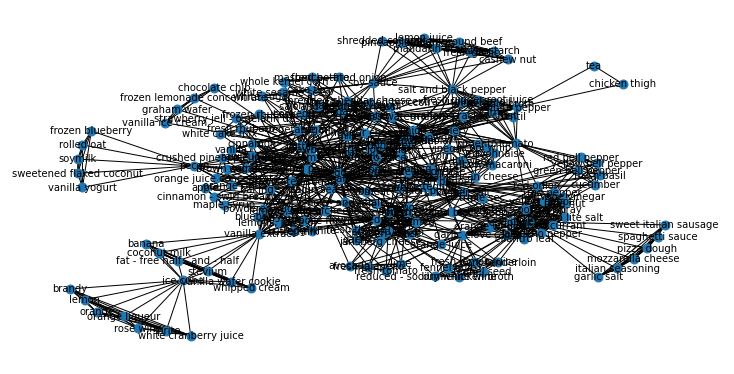

In [20]:

# nxG = nx.from_pandas_edgelist(edgeZwerg, 'ing1', 'ing2')
nxG = nx.from_pandas_edgelist(ingEdgeList.head(1000), 'ing1', 'ing2')

plt.figure(1, figsize=(10,5))
# pos = nx.random_layout(nxG, seed=42)
pos = nx.draw_kamada_kawai(nxG, node_size=80, font_size=10, with_labels=True)

nxG.nodes()

## Plot interactive connection graph

* https://plotly.com/python/network-graphs/



In [21]:
# https://www.kaggle.com/anand0427/network-graph-with-at-t-data-using-plotly

# Getting node positions
# pos = nx.spring_layout(nxG)
pos = nx.kamada_kawai_layout(nxG)

#Adding positions of the nodes to the graph¶
for n, p in pos.items():
    nxG.nodes[n]['pos'] = p

# Adding nodes and edges to the plotly api
edge_trace = go.Scatter(
    x=[],
    y=[],
    line=dict(width=0.5,color='#888'),
    hoverinfo='none',
    mode='lines')

for edge in nxG.edges():
    x0, y0 = nxG.nodes[edge[0]]['pos']
    x1, y1 = nxG.nodes[edge[1]]['pos']
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])

node_trace = go.Scatter(
    x=[],
    y=[],
    text=[],
    mode='markers',
    hoverinfo='text',
    marker=dict(
        showscale=True,
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=15,
        colorbar=dict(
            thickness=10,
            title='Node Connections',
            xanchor='left',
            titleside='right'
        ),
        line=dict(width=0)))

for node in nxG.nodes():
    x, y = nxG.nodes[node]['pos']
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])


# Coloring nodes
for node, adjacencies in enumerate(nxG.adjacency()):
    node_trace['marker']['color']+=tuple([len(adjacencies[1])])
    node_info = adjacencies[0] +' # of connections: '+str(len(adjacencies[1]))
    node_trace['text']+=tuple([node_info])


# Plotting the figure
fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                title='<br>Ingredient Connections',
                titlefont=dict(size=16),
                showlegend=False,
                hovermode='closest',
                margin=dict(b=20,l=5,r=5,t=40),
                annotations=[ dict(
                    text="No. of connections",
                    showarrow=False,
                    xref="paper", yref="paper") ],
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

iplot(fig)

# plotly.plot(fig)